In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/best_unet_v3_model/keras/default/1/best_Unet_V3_model.keras
/kaggle/input/best_unet_v3_model/keras/default/1/Unet_V3_model.keras
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_062.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/08_00_082.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-52.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_242.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/05_00_013.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/02_00_183.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F9-22.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F10-43.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/F66-12.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/06_00_193.png
/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/10_00_063

In [4]:
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 8.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import tensorflow as tf
import numpy as np

import keras

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


# from test_utils import summary, comparator


import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio.v2 as imageio


import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')



In [6]:
import tensorflow as tf

try:
    # Detect and initialize the TPU
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    # Use one of these two lines to confirm:
    print("Running on TPU at", resolver.master())
    #—or—
    print(f"Running on {strategy.num_replicas_in_sync} TPU cores")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("TPU not found, using", type(strategy).__name__)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1749315246.299508      10 service.cc:148] XLA service 0x5c987c5f5af0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749315246.299566      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1749315246.299571      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1749315246.299578      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1749315246.299581      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1749315246.299584      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1749315246.299586      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1749315246.299589      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1749315246.299591      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [7]:
path = '/kaggle/input/lyft-udacity-challenge'
x = ["A", "B", "C", "D", "E"]

# Initialize empty lists outside the loop
image_list = []
mask_list = []

for i in x:
    image_path = os.path.join(f"{path}/data{i}/data{i}/CameraRGB/")
    mask_path = os.path.join(f"{path}/data{i}/data{i}/CameraSeg/")
    
    image_list_orig = os.listdir(image_path)
    
    # Extend the list to keep adding images
    image_list.extend([image_path + img for img in image_list_orig])
    mask_list.extend([mask_path + img for img in image_list_orig])

# Now image_list and mask_list will each contain 10,000 entries
print(f"Total images collected: {len(image_list)}")
print(f"Total masks collected: {len(mask_list)}")
# print(mask_list[2])
# print(image_list[2])

Total images collected: 5000
Total masks collected: 5000


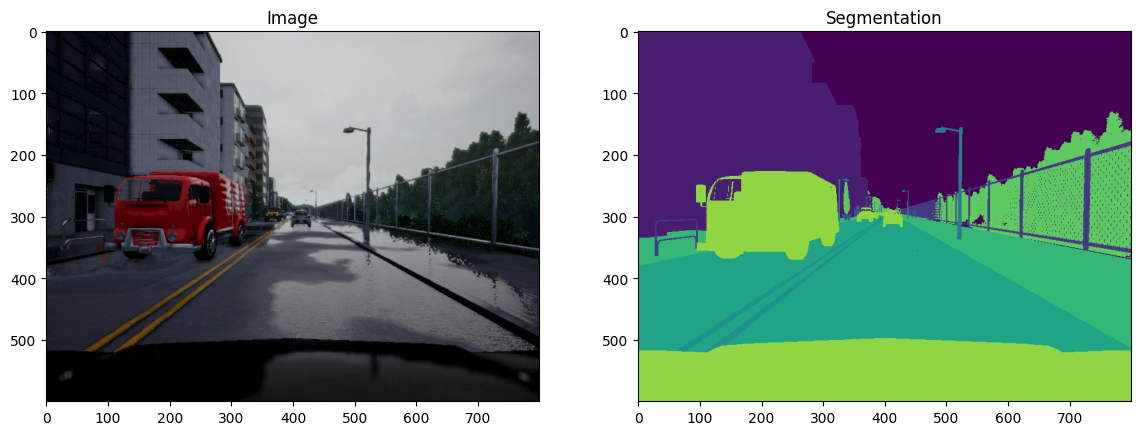

In [8]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show() 

In [9]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)



image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)


(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png'>)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png', shape=(), dtype=string)


In [10]:
# GLOBAL_BATCH_SIZE = 32
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')         

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
processed_image_ds = (
    image_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation="relu",
                  padding="same",
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation="relu",
                  padding="same",
                  # set 'kernel_initializer' same as above
                  kernel_initializer="he_normal")(conv)
    
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         
        conv = Dropout(dropout_prob)(conv)
         
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
                
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection




def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation="relu",
                  padding="same",
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation="relu",
                  padding="same",
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)

    
    return conv



def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    
    cblock1 = conv_block(inputs,  n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    
    cblock2 = conv_block(inputs=cblock1[0], n_filters=2*n_filters)
    
    cblock3 =conv_block(inputs=cblock2[0], n_filters=4*n_filters)
    
    cblock4 = conv_block(inputs=cblock3[0], n_filters=8*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    
    cblock5 = conv_block(inputs=cblock4[0], n_filters=16*n_filters, dropout_prob=0.3, max_pooling=False) 
    
   
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters=8*n_filters)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters=4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters=2*n_filters)
    ublock9 = upsampling_block(ublock8,cblock1[1], n_filters=n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    
    conv10 = Conv2D(n_classes, 1,activation="linear", padding="same")(conv9)
        
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [10]:
img_height = 96
img_width = 128

num_channels = 3

with strategy.scope():
    unet = unet_model((img_height, img_width, num_channels))
    unet.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


unet.summary()

I0000 00:00:1749309913.521071      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 128,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 128,   │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 12, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

(600, 800, 1)


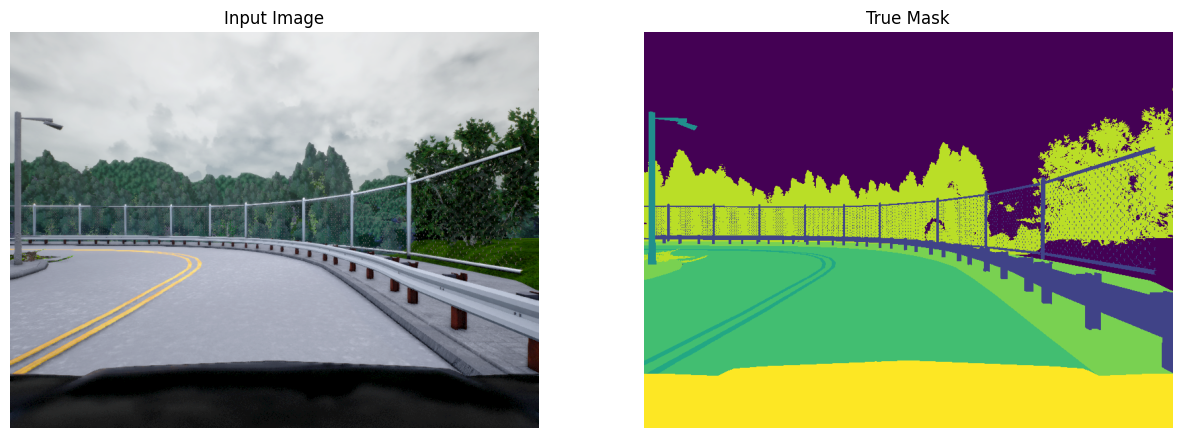

(96, 128, 1)


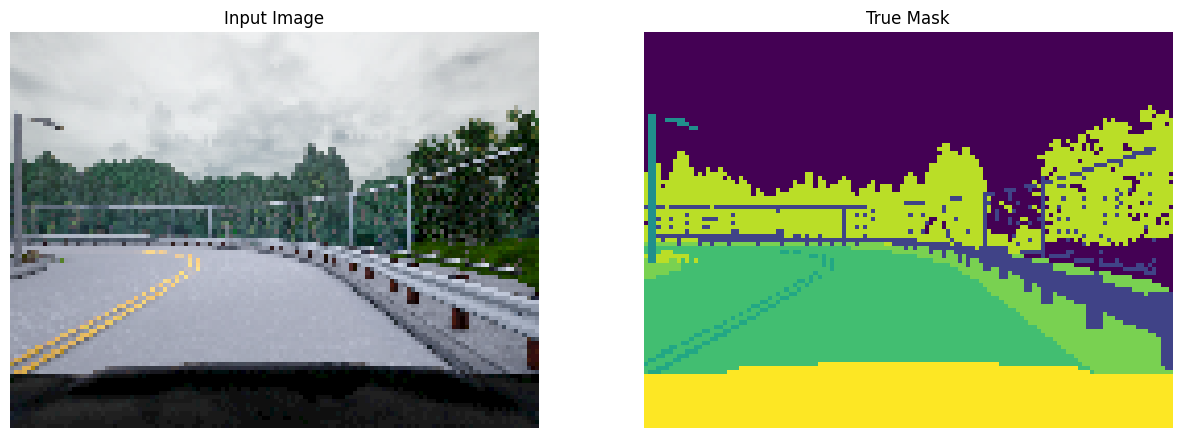

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# image_batch1, mask_batch2 = next(iter(image_ds))

# # Pull out the first sample from that batch
# sample_image = image_batch[0]   # → (592, 800, 3)
# sample_mask  = mask_batch[0]    # → (592, 800, 1) or (592, 800, 3)

# print(sample_image.shape, sample_mask.shape)
# display([sample_image, sample_mask])

# image_batch, mask_batch = next(iter(processed_image_ds))

# # Pull out the first sample from that batch
# sample_image = image_batch[0]   # → (592, 800, 3)
# sample_mask  = mask_batch[0]    # → (592, 800, 1) or (592, 800, 3)

# print(sample_image.shape, sample_mask.shape)
# display([sample_image, sample_mask])

for image, mask in image_ds.take(1):
    # sample_image, sample_mask = image, mask
    sample_image = image
    sample_mask = mask
    print(mask.shape)
display([sample_image, sample_mask])



for image, mask in processed_image_ds.take(1):
    # sample_image, sample_mask = image, mask
    sample_image = image
    sample_mask = mask
    print(mask.shape)
display([sample_image, sample_mask])

In [13]:
EPOCHS = 15
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()
# train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = processed_image_ds.take(4000).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = processed_image_ds.skip(4000).take(1000).cache().batch(BATCH_SIZE)

print(f"Train batches: {len(list(train_dataset))}")
print(f"Val batches: {len(list(val_dataset))}")


print(processed_image_ds.element_spec)

Train batches: 125
Val batches: 32
(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4335 - loss: 1.8735
Epoch 1: val_loss improved from inf to 0.51240, saving model to best_Unet_V3_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.4351 - loss: 1.8681 - val_accuracy: 0.8397 - val_loss: 0.5124
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8501 - loss: 0.4788
Epoch 2: val_loss improved from 0.51240 to 0.38657, saving model to best_Unet_V3_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8503 - loss: 0.4784 - val_accuracy: 0.8830 - val_loss: 0.3866
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9033 - loss: 0.3172
Epoch 3: val_loss improved from 0.38657 to 0.26649, saving model to best_Unet_V3_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9034 - loss: 0.3171 - val_accuracy: 0.9165 - val_loss: 0.2665
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9241 - loss: 0.2435
Epoch 4: val_loss improved from

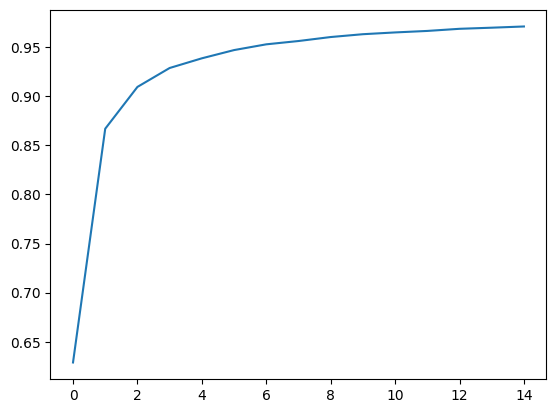

In [13]:
steps_per_epoch = 4000 // BATCH_SIZE
validation_steps = 1000 // BATCH_SIZE


unet = unet_model((img_height, img_width, num_channels))
unet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)


# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_Unet_V3_model.keras",         # file path
    monitor='val_loss',
    save_best_only=True,          # only save model when val_loss improves
    save_weights_only=False,      # save entire model
    verbose=1
)


# Fit the model
model_history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# unet.save("Unet_V3_model.h5")
keras.saving.save_model(unet, "Unet_V3_model.keras")



def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]



plt.plot(model_history.history["accuracy"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


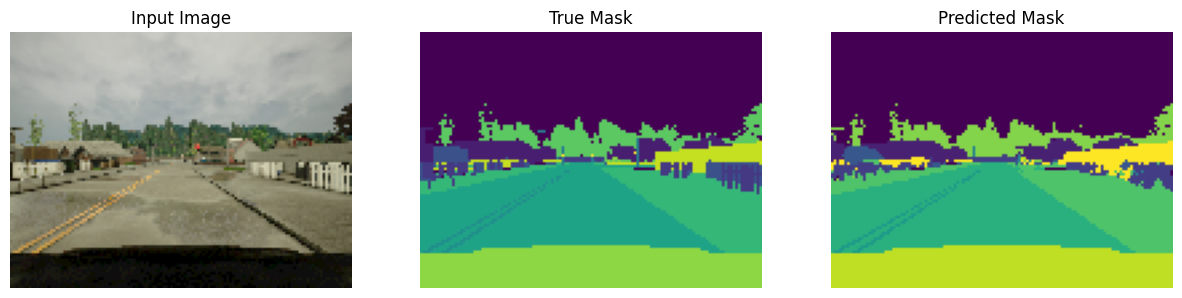

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


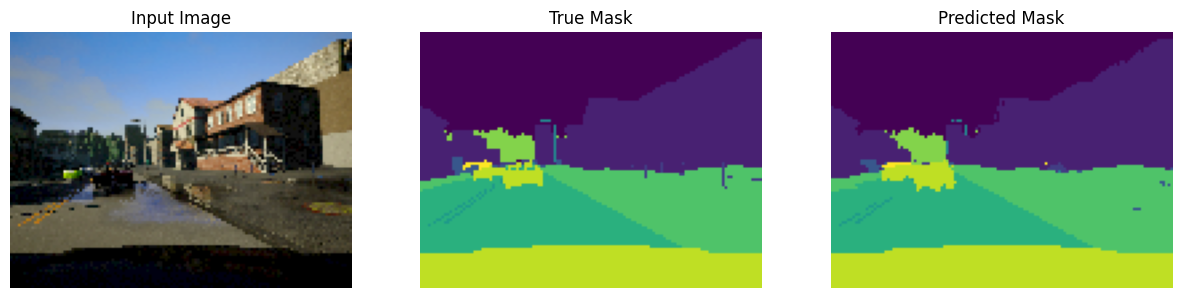

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


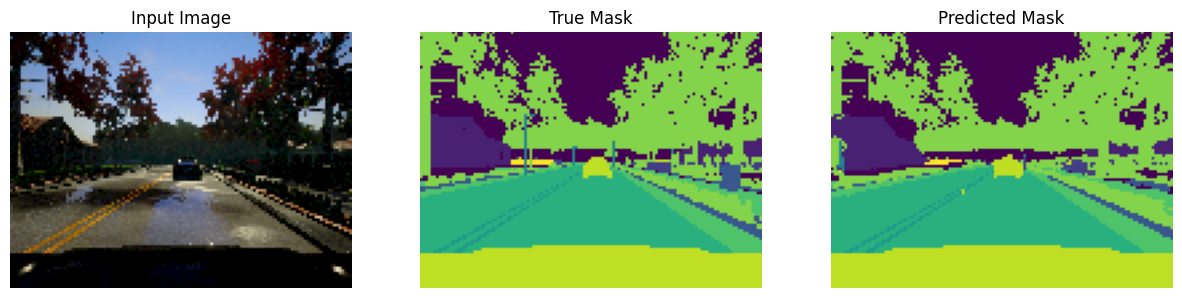

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


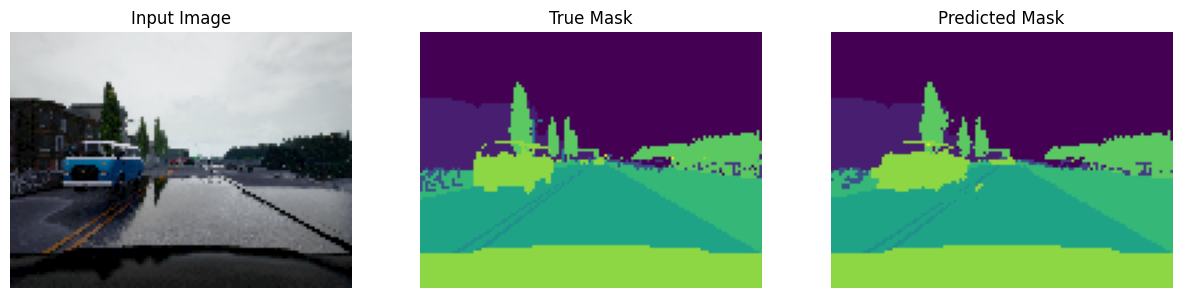

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


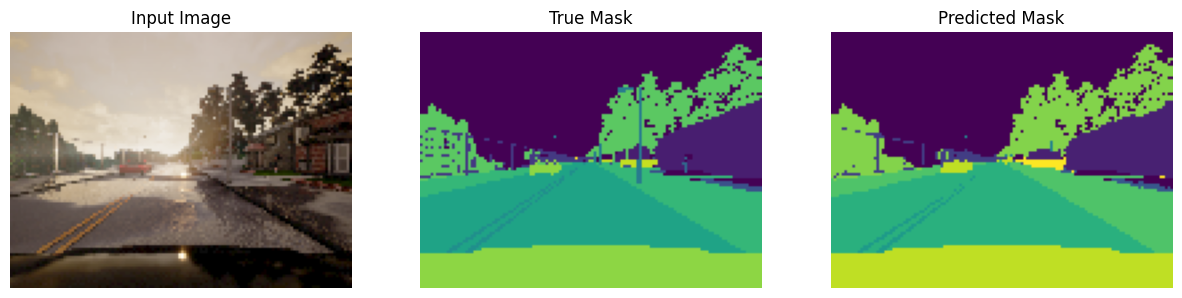

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


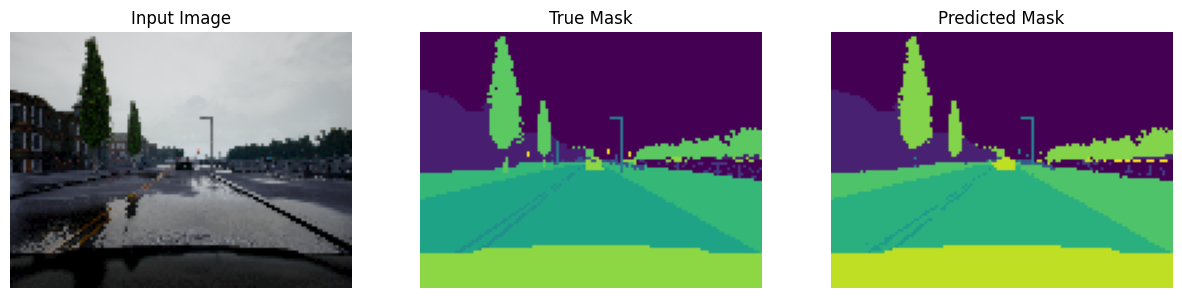

In [15]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    unet = tf.keras.models.load_model('/kaggle/input/best_unet_v3_model/keras/default/1/best_Unet_V3_model.keras')
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])


def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

show_predictions(train_dataset, 6)
